# Data Science - Laboratorio 3
## Modelos Long-Short Term Memory (LSTM)
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- - -

### Librerias
- - -

In [16]:
# Manejo de archivos
import os 

# Manipulación de datos
import pandas as pd
import numpy as np
from datetime import datetime


# Visualización
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Estadística y series temporales
import statsmodels.tsa as tsa
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# advertencias
import warnings
warnings.filterwarnings('ignore')

- - -
### Cargar los datasets
- - -

In [17]:
# Ruta de la carpeta con los archivos
folder_path = 'data'

# Obtener los nombres de los archivos
file_names = [file for file in os.listdir(folder_path) if file.endswith('.csv') and not file.startswith('~')]

# Diccionario para almacenar los dataframes
data_frames = {}

# Iterar sobre los nombres de los archivos
for file in file_names:
    # Construir la ruta del archivo
    file_path = os.path.join(folder_path, file)
    file_name = file.split('.')[0]
    
    # Leer el archivo csv y almacenarlo en un dataframe
    df = pd.read_csv(file_path, sep=';', encoding='utf-8')
    
    # Guardar el dataframe en el diccionario con el nombre del archivo como clave
    data_frames[file_name] = df

# Mostrar los nombres de los archivos
print(f"Se cargaron un total de {len(data_frames)} archivos\n")
print('Archivos cargados:')
for key in data_frames.keys():
    print(f"\t- {key}")

Se cargaron un total de 3 archivos

Archivos cargados:
	- consumos_combustibles
	- importaciones_combustibles
	- precios_combustibles


- - -
### Verificación y Manejo de valores nulos o faltantes
- - -

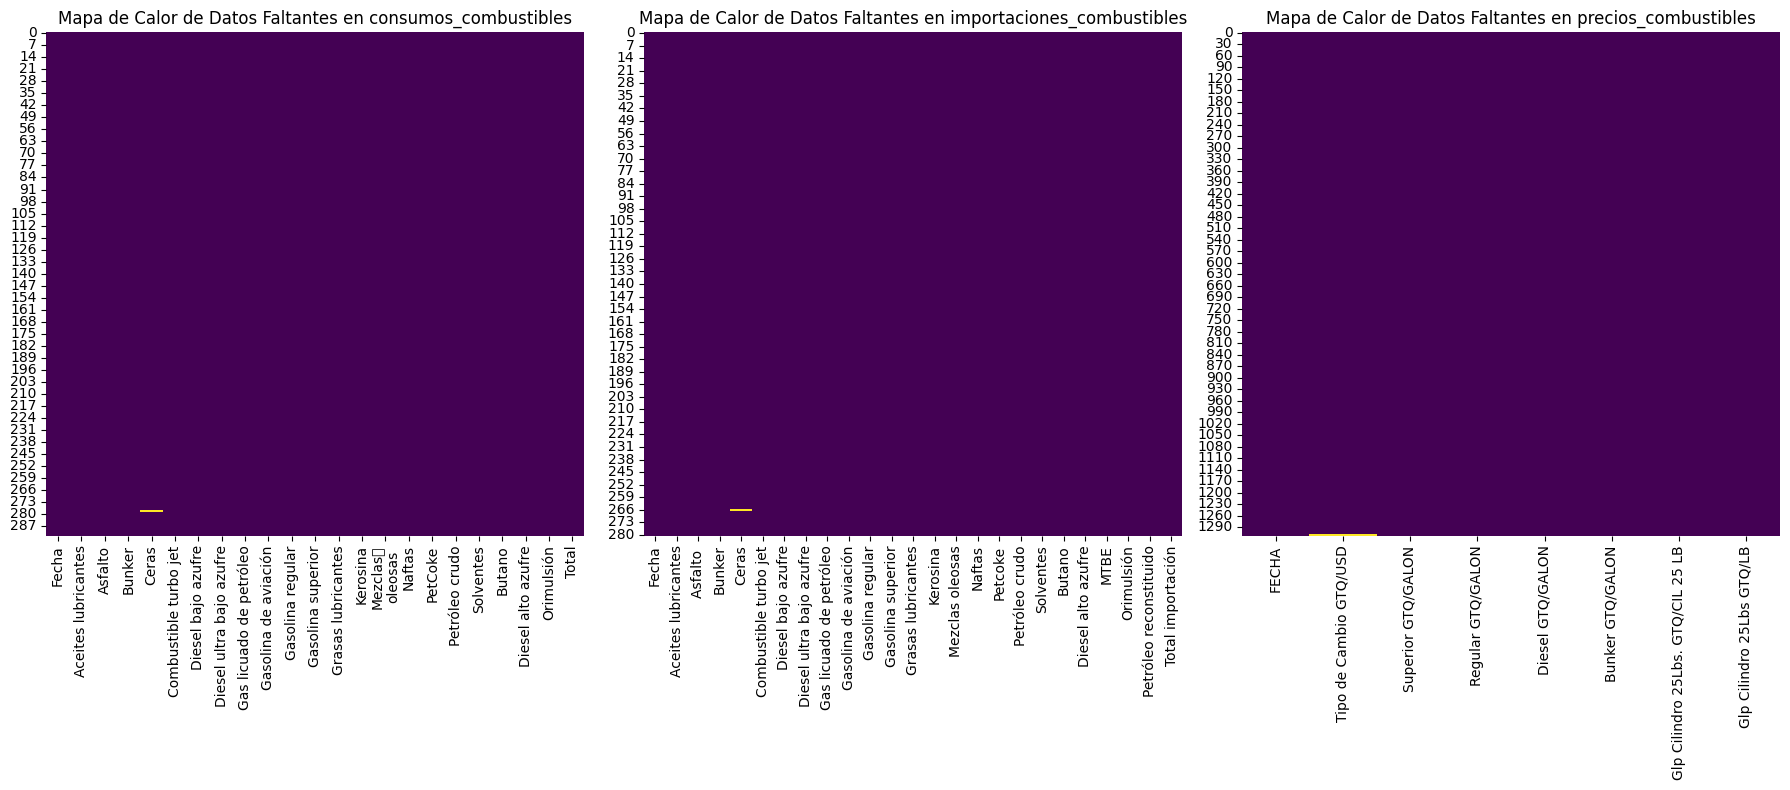

In [18]:
# Crear los subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Iterar sobre los dataframes en el diccionario
for ax, (key, df) in zip(axes, data_frames.items()):
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', ax=ax)
    ax.set_title(f'Mapa de Calor de Datos Faltantes en {key}')

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()
plt.show()

In [19]:
# Cargar cada dataset como su propio dataframe
consumos = data_frames['consumos_combustibles']
#importaciones = data_frames['importaciones_combustibles']
#precios = data_frames['precios_combustibles']

# Calcular la media de la columna "Ceras"
media_ceras = consumos['Ceras'].mean()

# Reemplazar los valores nulos en la columna "Ceras" con la media
consumos['Ceras'].fillna(media_ceras, inplace=True)

# Eliminar los registros con valores nulos en otras columnas
consumos.dropna(inplace=True)
#importaciones.dropna(inplace=True)
#precios.dropna(inplace=True)

# Comprobar si hay valores nulos
print("Valores nulos en el dataset de consumo de combustibles:", consumos.isnull().sum().sum())
#print("Valores nulos en el dataset de importación de combustibles:", importaciones.isnull().sum().sum())
#print("Valores nulos en el dataset de precios de combustibles:", precios.isnull().sum().sum())

Valores nulos en el dataset de consumo de combustibles: 0


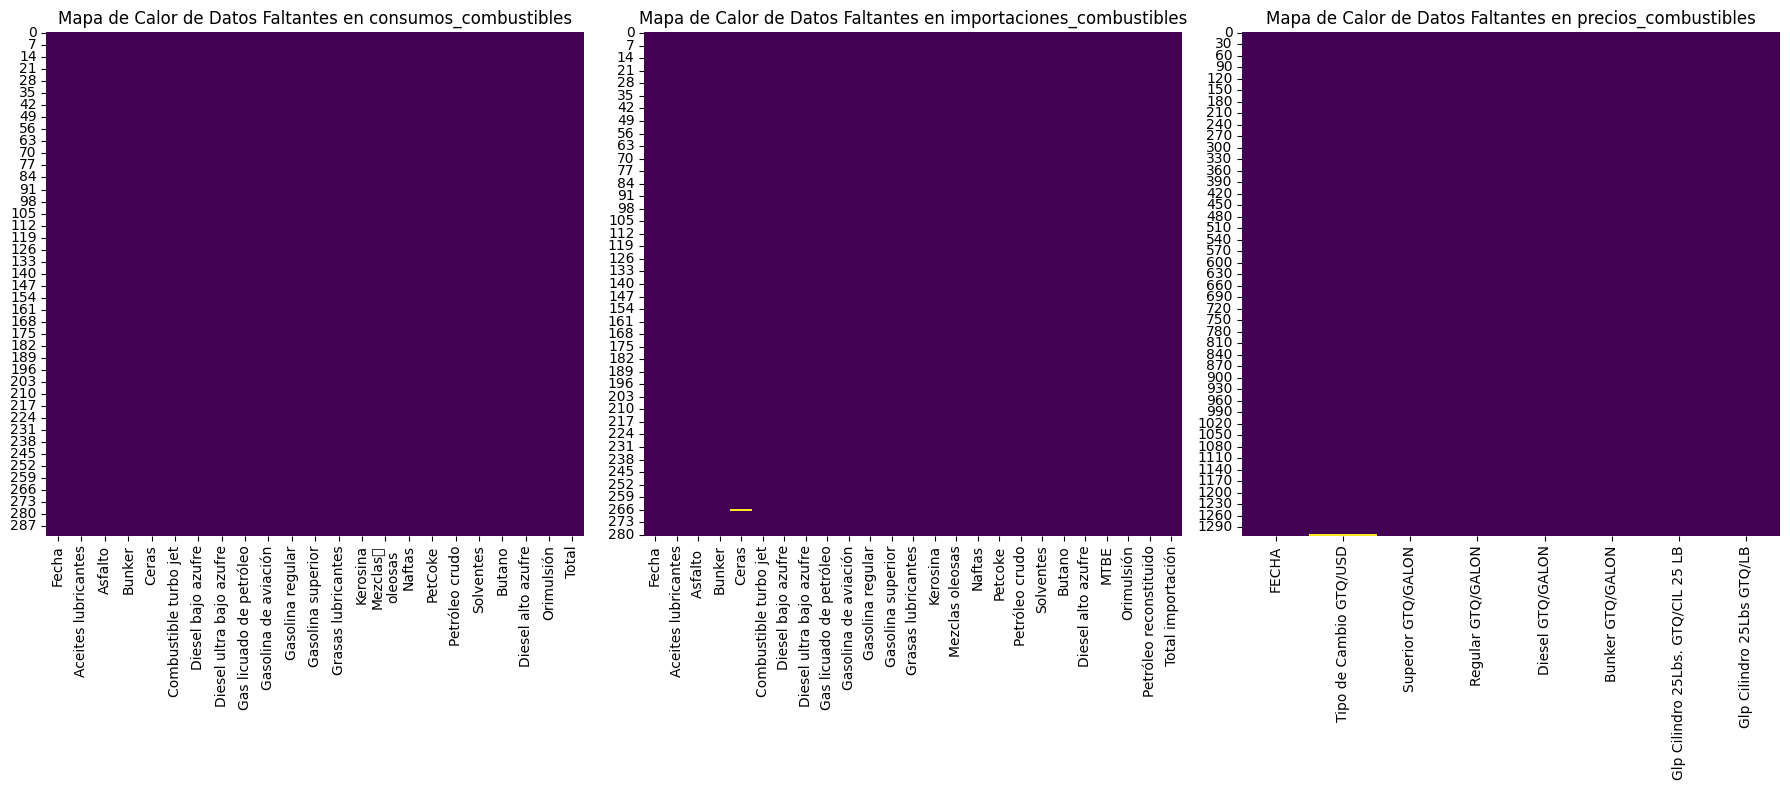

In [20]:
# Crear los subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Iterar sobre los dataframes en el diccionario
for ax, (key, df) in zip(axes, data_frames.items()):
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', ax=ax)
    ax.set_title(f'Mapa de Calor de Datos Faltantes en {key}')

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()
plt.show()

In [25]:
consumos = pd.read_csv('data/consumos_combustibles.csv', delimiter=';')

# Crear un nuevo dataset con solo la columna "Gasolina Regular"
gasolina_regular = consumos[['Fecha', 'Gasolina regular']]

# Guardar el nuevo dataset en un archivo CSV
gasolina_regular.to_csv('data/consumos_gasolina_regular.csv', index=False)


### Descomposición Series

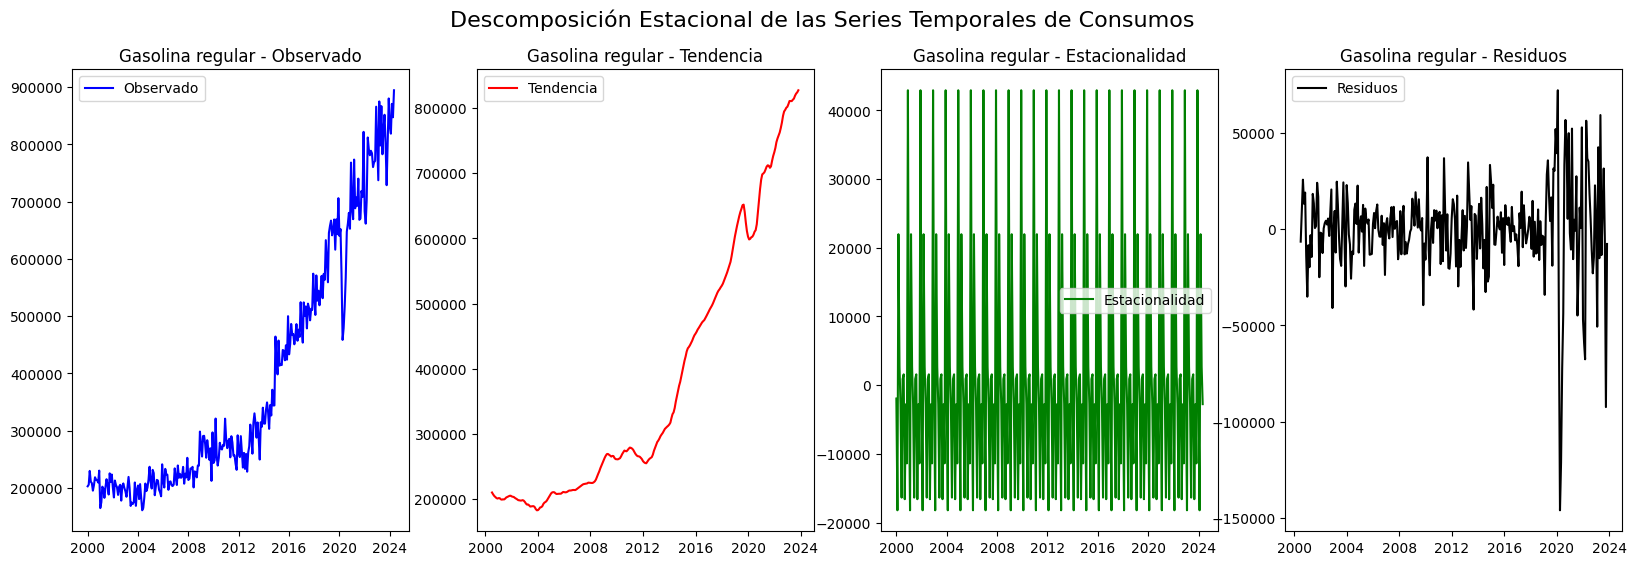

In [28]:
def seasonal_decomposition(data, period=12):
    decompositions = {}
    num_vars = len(data.columns)
    fig, axes = plt.subplots(num_vars, 4, figsize=(20, 6 * num_vars))

    if num_vars == 1:
        axes = [axes]

    for i, column in enumerate(data.columns):
        decomposition = seasonal_decompose(data[column], period=period)
        decompositions[column] = {
            'observed': decomposition.observed,
            'trend': decomposition.trend,
            'seasonal': decomposition.seasonal,
            'resid': decomposition.resid
        }

        # Graficar Observado
        axes[i][0].plot(data.index, decomposition.observed, label='Observado', color='blue')
        axes[i][0].set_title(f'{column} - Observado')
        axes[i][0].legend()
        axes[i][0].grid(False)

        # Graficar Tendencia
        axes[i][1].plot(data.index, decomposition.trend, label='Tendencia', color='red')
        axes[i][1].set_title(f'{column} - Tendencia')
        axes[i][1].legend()
        axes[i][1].grid(False)

        # Graficar Estacionalidad
        axes[i][2].plot(data.index, decomposition.seasonal, label='Estacionalidad', color='green')
        axes[i][2].set_title(f'{column} - Estacionalidad')
        axes[i][2].legend()
        axes[i][2].grid(False)

        # Graficar Residuos
        axes[i][3].plot(data.index, decomposition.resid, label='Residuos', color='black')
        axes[i][3].set_title(f'{column} - Residuos')
        axes[i][3].legend()
        axes[i][3].grid(False)

    plt.suptitle('Descomposición Estacional de las Series Temporales de Consumos', fontsize=16)
    plt.tight_layout(rect=[0, 0.83, 1, 0.95])
    plt.show()

    return decompositions

# Cargar el dataset de gasolina regular
gasolina_regular = pd.read_csv('data/consumos_gasolina_regular.csv')

# Convertir la columna 'Fecha' a índice de fecha
meses_es = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

gasolina_regular['Fecha'] = gasolina_regular['Fecha'].replace(meses_es, regex=True)
gasolina_regular['Fecha'] = pd.to_datetime(gasolina_regular['Fecha'], format='%b/%Y')
gasolina_regular.set_index('Fecha', inplace=True)

# Aplicar la descomposición estacional
decompositions = seasonal_decomposition(gasolina_regular[['Gasolina regular']], period=12)

### Prueba Augmented Dickey-Fuller & Prueba Kwiatkowski-Phillips-Schmidt-Shin

In [30]:
def adf_test(series, title='', autolag=True):
    print(f'Resultados de Prueba ADF: {title}')
    if autolag:
        result = adfuller(series, autolag='AIC')
    else:
        result = adfuller(series)
    output = pd.Series(result[0:4], index=['Estadístico de prueba', 'p-value', '# de retardos usados', '# de observaciones usadas'])
    for key, value in result[4].items():
        output[f'valor crítico ({key})'] = value
    print(output)
    print('Conclusión:')
    if result[1] <= 0.05:
        print(f"El valor P ({result[1]:.4f}) es menor o igual a 0.05 -> Rechazamos la hipótesis nula -> La serie temporal es estacionaria")
    else:
        print(f"El valor P ({result[1]:.4f}) es mayor a 0.05 -> No se rechaza la hipótesis nula -> La serie temporal no es estacionaria")

def kpss_test(series, title=''):
    print(f'Resultados de Prueba de KPSS: {title}')
    result = kpss(series, regression='c')
    output = pd.Series(result[0:3], index=['Estadístico de prueba', 'p-value', '# de retardos usados'])
    for key, value in result[3].items():
        output[f'valor crítico ({key})'] = value
    print(output)
    print('Conclusión:')
    if result[1] <= 0.05:
        print(f"El valor P ({result[1]:.4f}) es menor o igual a 0.05 -> Rechazamos la hipótesis nula -> La serie temporal no es estacionaria")
    else:
        print(f"El valor P ({result[1]:.4f}) es mayor a 0.05 -> No se rechaza la hipótesis nula -> La serie temporal es estacionaria")

# Cargar el dataset de gasolina regular
gasolina_regular = pd.read_csv('data/consumos_gasolina_regular.csv')

# Convertir la columna 'Fecha' a índice de fecha
meses_es = {
    'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
    'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'
}

gasolina_regular['Fecha'] = gasolina_regular['Fecha'].replace(meses_es, regex=True)
gasolina_regular['Fecha'] = pd.to_datetime(gasolina_regular['Fecha'], format='%b/%Y')
gasolina_regular.set_index('Fecha', inplace=True)

# Realizar las pruebas de estacionariedad
adf_test(gasolina_regular['Gasolina regular'], title='Gasolina Regular')
kpss_test(gasolina_regular['Gasolina regular'], title='Gasolina Regular')

Resultados de Prueba ADF: Gasolina Regular
Estadístico de prueba          2.712414
p-value                        0.999088
# de retardos usados          14.000000
# de observaciones usadas    278.000000
valor crítico (1%)            -3.454094
valor crítico (5%)            -2.871993
valor crítico (10%)           -2.572340
dtype: float64
Conclusión:
El valor P (0.9991) es mayor a 0.05 -> No se rechaza la hipótesis nula -> La serie temporal no es estacionaria
Resultados de Prueba de KPSS: Gasolina Regular
Estadístico de prueba     2.46678
p-value                   0.01000
# de retardos usados     10.00000
valor crítico (10%)       0.34700
valor crítico (5%)        0.46300
valor crítico (2.5%)      0.57400
valor crítico (1%)        0.73900
dtype: float64
Conclusión:
El valor P (0.0100) es menor o igual a 0.05 -> Rechazamos la hipótesis nula -> La serie temporal no es estacionaria


### Transformaciones

In [31]:
# Aplicar transformación logarítmica a los datos de consumo para hacerlos estacionarios en varianza
gasolina_regular_log = np.log(gasolina_regular)

# Aplicar transformación diferencial a los datos de consumo para hacerlos estacionarios en tendencia
gasolina_regular_diff = gasolina_regular_log.diff().dropna()

# Realizar pruebas de estacionariedad a los datos transformados
print("Pruebas de Estacionariedad para los datos transformados de Gasolina Regular")

adf_test(gasolina_regular_diff['Gasolina regular'], title='Gasolina Regular transformada')
kpss_test(gasolina_regular_diff['Gasolina regular'], title='Gasolina Regular transformada')

Pruebas de Estacionariedad para los datos transformados de Gasolina Regular
Resultados de Prueba ADF: Gasolina Regular transformada
Estadístico de prueba       -6.266068e+00
p-value                      4.111214e-08
# de retardos usados         1.100000e+01
# de observaciones usadas    2.800000e+02
valor crítico (1%)          -3.453922e+00
valor crítico (5%)          -2.871918e+00
valor crítico (10%)         -2.572300e+00
dtype: float64
Conclusión:
El valor P (0.0000) es menor o igual a 0.05 -> Rechazamos la hipótesis nula -> La serie temporal es estacionaria
Resultados de Prueba de KPSS: Gasolina Regular transformada
Estadístico de prueba     0.220349
p-value                   0.100000
# de retardos usados     17.000000
valor crítico (10%)       0.347000
valor crítico (5%)        0.463000
valor crítico (2.5%)      0.574000
valor crítico (1%)        0.739000
dtype: float64
Conclusión:
El valor P (0.1000) es mayor a 0.05 -> No se rechaza la hipótesis nula -> La serie temporal es estacio

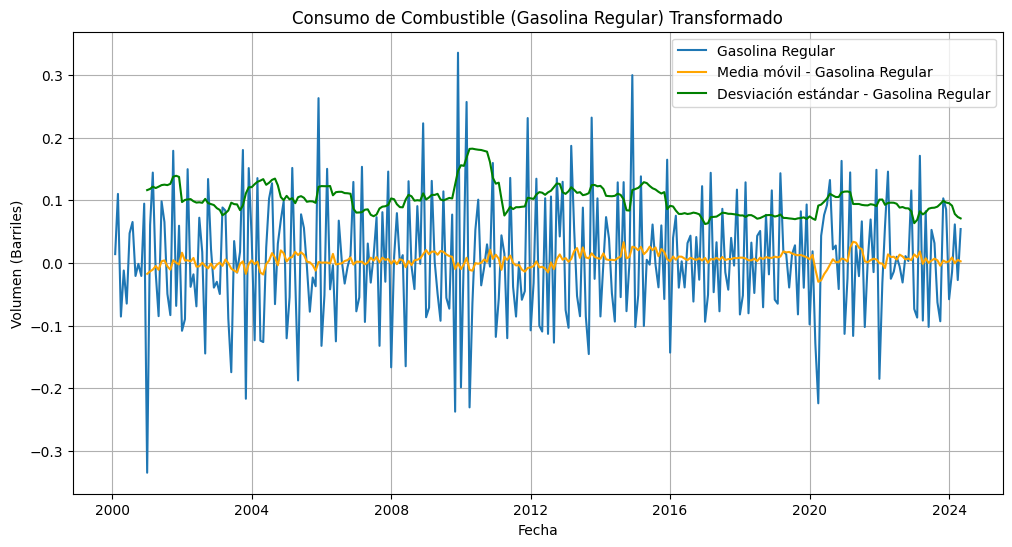

In [34]:
# Gráfico de la serie temporal transformada de "Gasolina Regular"
def plot_transformed_data(data, title='', ylabel=''):
    rolling_mean = data.rolling(window=12).mean()
    rolling_std = data.rolling(window=12).std()
    
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Gasolina Regular')
    plt.plot(rolling_mean, label='Media móvil - Gasolina Regular', color='orange')
    plt.plot(rolling_std, label='Desviación estándar - Gasolina Regular', color='green')
    plt.title(title)
    plt.xlabel('Fecha')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_transformed_data(
    gasolina_regular_diff['Gasolina regular'],
    title='Consumo de Combustible (Gasolina Regular) Transformado',
    ylabel='Volumen (Barriles)'
)

### Autocorrelación y Autocorrelación Parcial

In [36]:
# Datos transformados
data_diff = gasolina_regular_diff['Gasolina regular']

# Calcular ACF y PACF
data_acf = acf(data_diff, nlags=36, fft=False)
data_pacf = pacf(data_diff, nlags=36)

print(f"ACF: {data_acf}\n")
print(f"PACF: {data_pacf}\n")

ACF: [ 1.         -0.40563162 -0.12981277  0.12041332 -0.04708529  0.13674057
 -0.26275813  0.09741006  0.00275576  0.11434711 -0.13179924 -0.20983178
  0.4807525  -0.24723303 -0.07476462  0.06281692  0.01866047  0.17290999
 -0.29601696  0.08063682  0.0315938   0.0945261  -0.08248535 -0.19454834
  0.45032474 -0.25469882 -0.04239132  0.04637371  0.02802767  0.13553349
 -0.28136152  0.09686444  0.03998675  0.05627424 -0.06705097 -0.23684459
  0.41934479]

PACF: [ 1.00000000e+00 -4.07025538e-01 -3.55228441e-01 -1.30339719e-01
 -1.17036210e-01  1.33095644e-01 -2.02280110e-01 -9.43347497e-02
 -1.68348577e-01  1.36765772e-01 -7.12050953e-02 -3.13530503e-01
  2.16819868e-01 -8.37882391e-04 -6.86478728e-02 -7.61612959e-02
  1.12654117e-02  1.53096461e-01 -7.41339911e-02 -6.87665527e-02
 -8.04414504e-02  4.12288424e-02  5.16730476e-02 -8.98022424e-02
  2.35781903e-01  2.97793457e-03  3.06145663e-04  1.06964805e-02
  1.09442323e-01  7.68760966e-02 -4.09277401e-02 -1.08932198e-02
  2.04635953e-02

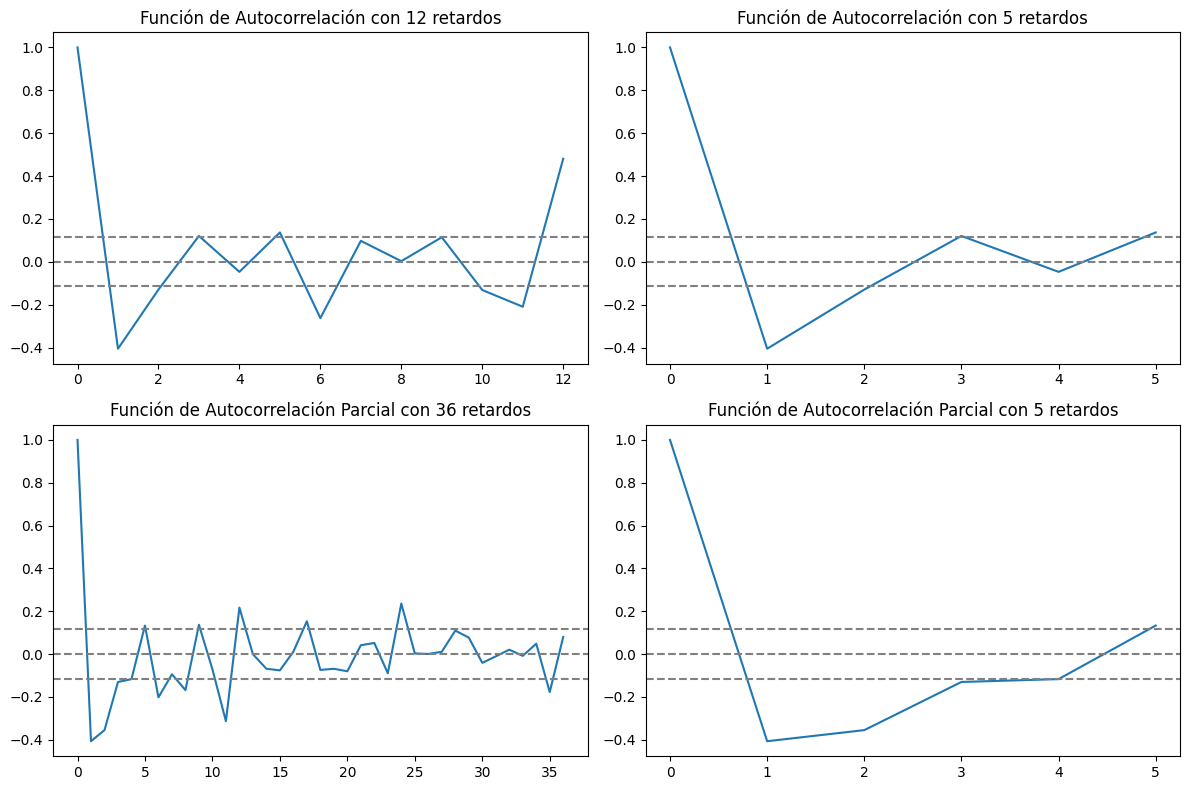

In [37]:
# Configurar el tamaño de la figura
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Subplot 1: ACF con 12 retardos
axs[0, 0].plot(acf(data_diff, nlags=12, fft=False))
axs[0, 0].axhline(y=0, linestyle='--', color='gray')
axs[0, 0].axhline(y=1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
axs[0, 0].axhline(y=-1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
axs[0, 0].set_title('Función de Autocorrelación con 12 retardos')

# Subplot 2: ACF con 5 retardos
axs[0, 1].plot(acf(data_diff, nlags=5, fft=False))
axs[0, 1].axhline(y=0, linestyle='--', color='gray')
axs[0, 1].axhline(y=1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
axs[0, 1].axhline(y=-1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
axs[0, 1].set_title('Función de Autocorrelación con 5 retardos')

# Subplot 3: PACF con 36 retardos
axs[1, 0].plot(pacf(data_diff, nlags=36))
axs[1, 0].axhline(y=0, linestyle='--', color='gray')
axs[1, 0].axhline(y=1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
axs[1, 0].axhline(y=-1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
axs[1, 0].set_title('Función de Autocorrelación Parcial con 36 retardos')

# Subplot 4: PACF con 5 retardos
axs[1, 1].plot(pacf(data_diff, nlags=5))
axs[1, 1].axhline(y=0, linestyle='--', color='gray')
axs[1, 1].axhline(y=1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
axs[1, 1].axhline(y=-1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
axs[1, 1].set_title('Función de Autocorrelación Parcial con 5 retardos')

# Ajustar el layout
plt.tight_layout()

# Mostrar la figura
plt.show()

### Estacionalidad

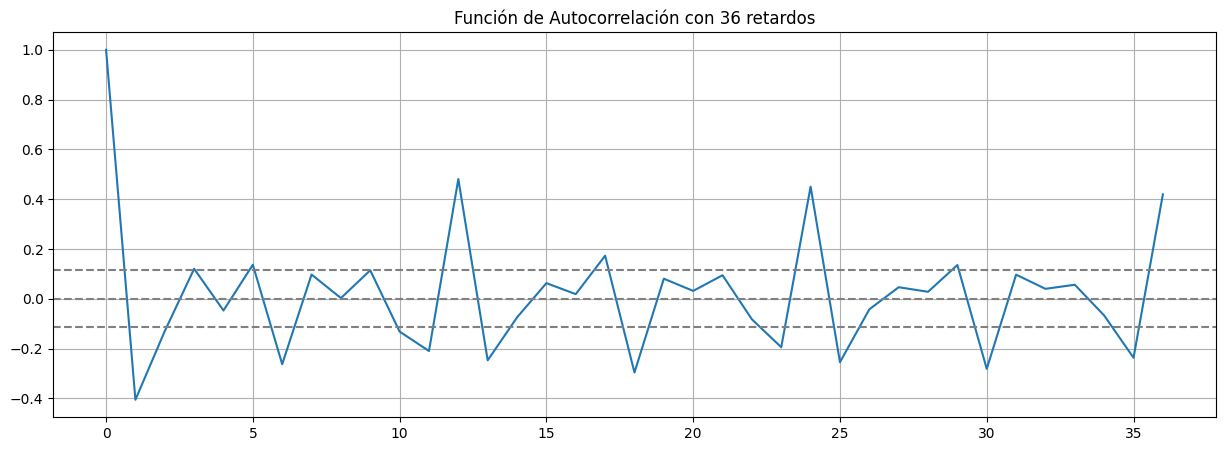

In [38]:
# Datos transformados
data_diff = gasolina_regular_diff['Gasolina regular']

# Calcular ACF con 36 retardos
data_acf = acf(data_diff, nlags=36, fft=False)

# Configurar el tamaño de la figura
plt.figure(figsize=[15, 5])
plt.plot(data_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.grid(True)

# Mostrar la figura
plt.show()

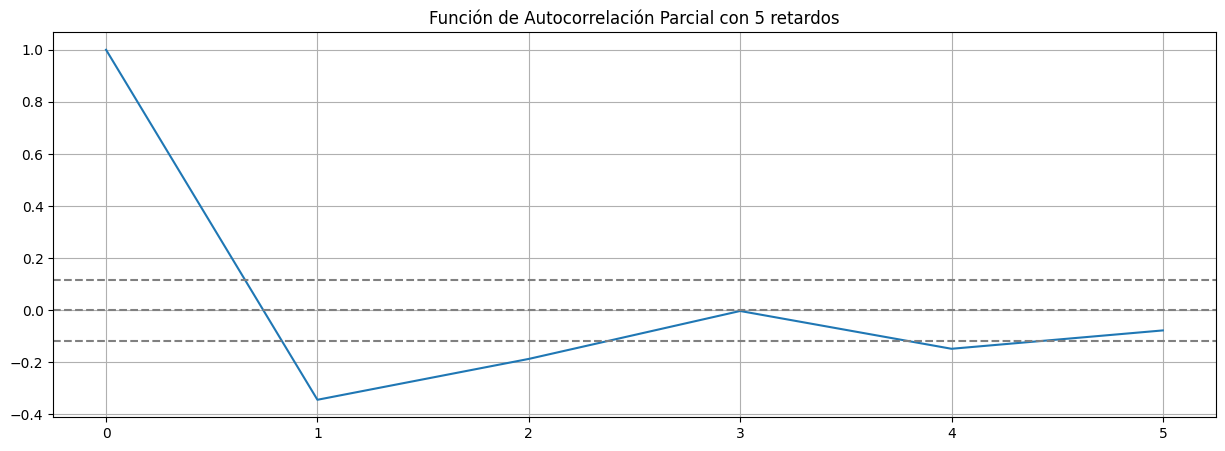

In [39]:
# Datos transformados
data_diff = gasolina_regular_diff['Gasolina regular']

# Calcular la diferencia estacional
data_diff_D = data_diff.diff(12)
data_diff_D.dropna(inplace=True)

# Calcular PACF con 5 retardos
data_pacf_D = pacf(data_diff_D, nlags=5)

# Configurar el tamaño de la figura
plt.figure(figsize=[15, 5])
plt.plot(data_pacf_D)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_diff_D)), linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_diff_D)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación Parcial con 5 retardos')
plt.grid(True)

# Mostrar la figura
plt.show()

In [42]:
def split_data(data, train_size=0.8):

    split_index = int(len(data) * train_size)
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data

# Dividir los datos transformados en conjuntos de entrenamiento y prueba
train_diff, test_diff = split_data(data_diff)

In [ ]:
Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=1. Se prueban los siguientes valores estacionales:
- P = 1
- D = 1
- Q = 3